In [1]:
import torch 
from torch import nn
from torchvision import datasets,transforms 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader,Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

train_data = datasets.MNIST(root='/data',download=True,train=True,transform=transform)
#test_data = datasets.MNIST(root='/data',download=True,train=False)
train_loader = DataLoader(dataset=train_data,batch_size=64,shuffle=True)

In [6]:
iter_obj = iter(train_loader)
image,label = next(iter_obj)
print(torch.min(image),torch.max(image))
print(image.shape)

tensor(-1.) tensor(1.)
torch.Size([64, 1, 28, 28])


In [8]:
class autoencoder(nn.Module):
    def __init__(self) -> None:
        #img size at begining(N,28*28) n is batch 
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28,out_features=128), # reduces size from n,784 (n,128)
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=12),
            nn.ReLU(),
            nn.Linear(12,3) #(n,3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features=3,out_features=12), # increases size from (n,3) -> (n,128784)
            nn.ReLU(),
            nn.Linear(in_features=12,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=128),
            nn.ReLU(),
            nn.Linear(128,28*28), #(n,3)
            nn.Tanh()
        )

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5) 

In [14]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (input,label) in train_loader:
        #print(f"image shape before reshaping: {input.shape}")
        input = input.reshape(-1,28*28).to(device)
        pred = model(input)
        loss = criterion(pred,input)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch + 1}, Loss: {loss.item():.4f}")
    outputs.append((epoch,input,pred))

epoch 1, Loss: 0.1691
epoch 2, Loss: 0.1441
epoch 3, Loss: 0.1529
epoch 4, Loss: 0.1652
epoch 5, Loss: 0.1369
epoch 6, Loss: 0.1391
epoch 7, Loss: 0.1363
epoch 8, Loss: 0.1348
epoch 9, Loss: 0.1406
epoch 10, Loss: 0.1345


In [15]:
outputs

[(0,
  tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]], device='cuda:0'),
  tensor([[-0.9854, -0.9823, -0.9837,  ..., -0.9867, -0.9840, -0.9798],
          [-0.9995, -0.9986, -0.9992,  ..., -0.9997, -0.9995, -0.9996],
          [-1.0000, -0.9999, -1.0000,  ..., -1.0000, -0.9999, -0.9999],
          ...,
          [-0.9968, -0.9964, -0.9962,  ..., -0.9983, -0.9974, -0.9962],
          [-0.9912, -0.9858, -0.9869,  ..., -0.9916, -0.9925, -0.9912],
          [-0.9997, -0.9993, -0.9998,  ..., -0.9998, -0.9996, -0.9995]],
         device='cuda:0', grad_fn=<TanhBackward0>)),
 (1,
  tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
        

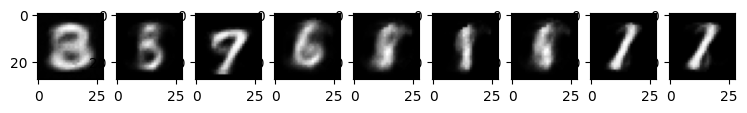

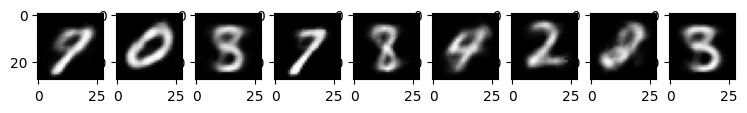

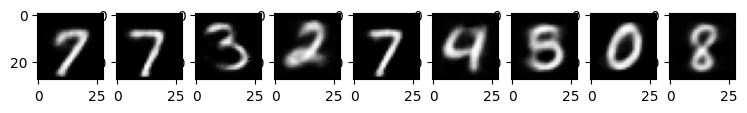

In [22]:
for k in range(0,num_epochs,4):
    plt.figure(figsize=(9,2))
    plt.gray()
    img = outputs[k][1].detach().cpu().numpy()
    pred = outputs[k][2].detach().cpu().numpy()
    for i,item in enumerate(img):
        item = item.reshape(-1,28,28)
        if i >= 9:
            break
        plt.subplot(2,9,i+1)
        plt.imshow(item[0])
    
    for i,item in enumerate(pred):
        item = item.reshape(-1,28,28)
        if i >= 9:
            break
        plt.subplot(2,9,i+1)
        plt.imshow(item[0])